# Reverse Correlation

In [3]:
import os
import glob
import pandas as pd
import numpy as np

from scipy import stats

import SUITPy.flatmap as flatmap
import matplotlib.pyplot as plt

from nilearn.maskers import NiftiLabelsMasker
from nilearn.plotting import plot_roi, plot_stat_map

## Setup

In [4]:
#bids_dir = '/data/neuron/NET/hpopal/'
bids_dir = '/Users/hpopal/Google Drive/My Drive/dscn_lab/projects/net/'
outp_dir = bids_dir + 'derivatives/reverse_correlation/'

os.chdir(bids_dir)

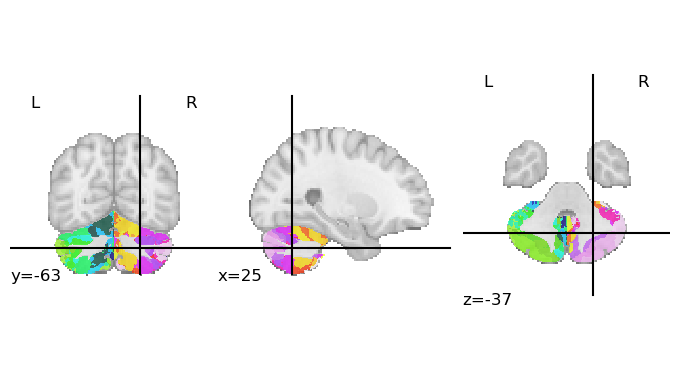

In [11]:
# cerebellum parcellation
cb_atlas = bids_dir + 'derivatives/rois/Nettekoven_2023/atl-NettekovenAsym32_space-MNI152NLin2009cSymC_dseg.nii'

plot_roi(cb_atlas)

In [13]:
cb_atlas_labels = pd.read_csv('derivatives/rois/Nettekoven_2023/atl-NettekovenAsym32.lut', sep=' ',
                             names=['Value', 'R', 'G', 'B', 'Label'])

cb_roi_names = cb_atlas_labels['Label'][1:]

cb_atlas_labels.head()

,Value,R,G,B,Label
0,0,0.0000,0.0000,0.0000,0
1,1,0.5035,0.3072,0.6261,M1L
2,2,0.6168,0.1613,0.8792,M2L
3,3,0.3973,0.7139,0.9749,M3L
4,4,0.3842,1.0000,0.4614,M4L


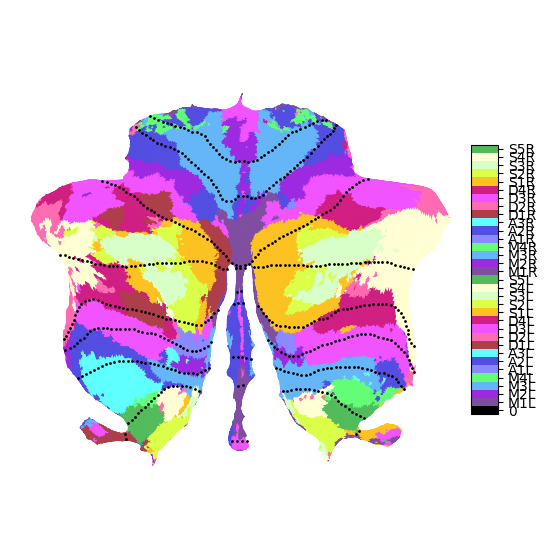

In [5]:
# Import as a flatmap
cb_atlas_flat = flatmap.plot(bids_dir+'derivatives/rois/Nettekoven_2023/atl-NettekovenAsym32_dseg.label.gii',
                             overlay_type='label',\
    new_figure=True, \
    colorbar=True)

In [5]:
mri_qc_data = pd.read_csv(bids_dir+'derivatives/participants-qc.csv')

# Remove T1 info
mri_qc_data = mri_qc_data[mri_qc_data['Run'] != 'T1']

# Createa a participants list
subjs_list = mri_qc_data['participant_id'].unique()

mri_qc_data.head()

,participant_id,Run
1,sub-NET011,run-1
2,sub-NET011,run-2
3,sub-NET011,run-3
4,sub-NET011,run-4
5,sub-NET011,run-5


In [7]:
subj = subjs_list[0]

fmri_run_paths = glob.glob(os.path.join(bids_dir, 'derivatives', 'fmriprep',
                                        subj, 'func',
                                        '*space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'))

# Sort to ensure the run number is correct
fmri_run_paths.sort()

print('Number of functional runs for '+subj+': '+str(len(fmri_run_paths)))

Number of functional runs for sub-NET011: 7


In [8]:
# Define a brain mask for easier registration between spaces
mni_mask = bids_dir+'derivatives/fmriprep/sub-NET011/func/sub-NET011_task-net_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz'


In [9]:
# Import confounds
confounds_raw_filenames = glob.glob(os.path.join(bids_dir, 'derivatives', 'fmriprep',
                                        subj, 'func',
                                        '*desc-confounds_timeseries.tsv'))
confounds_raw_filenames.sort()

relv_confounds = ['csf','white_matter',
                  'trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']

confounds_run1 = pd.read_csv(confounds_raw_filenames[0], sep='\t')
confounds_run1 = confounds_run1[relv_confounds]
confounds_run1 = confounds_run1.fillna(0)
confounds_run1.head()

,csf,white_matter,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
0,522.014531,296.485788,0.030503,0.080977,0.059600,-0.000095,-0.000436,0.000483
1,522.431392,295.965549,0.036858,0.166531,0.052719,-0.000262,-0.000465,0.000348
2,518.833142,296.506428,0.039397,-0.027910,0.029338,-0.000325,-0.000560,0.000459
3,519.877905,296.550108,0.037460,0.091761,0.058476,-0.000408,-0.000465,0.000448
4,520.978200,296.986907,0.025109,0.098204,0.025663,-0.000277,-0.000552,0.000303


In [10]:
from nilearn.maskers import NiftiLabelsMasker

# Instantiate the masker with label image and label values
masker = NiftiLabelsMasker(
    labels_img=cb_atlas,
    labels=cb_atlas_labels['Label'],
    mask_img=mni_mask,
    t_r=1.25, 
    strategy='mean',
    standardize="zscore_sample")

cb_data_ts = masker.fit_transform(fmri_run_paths[0], confounds_run1)




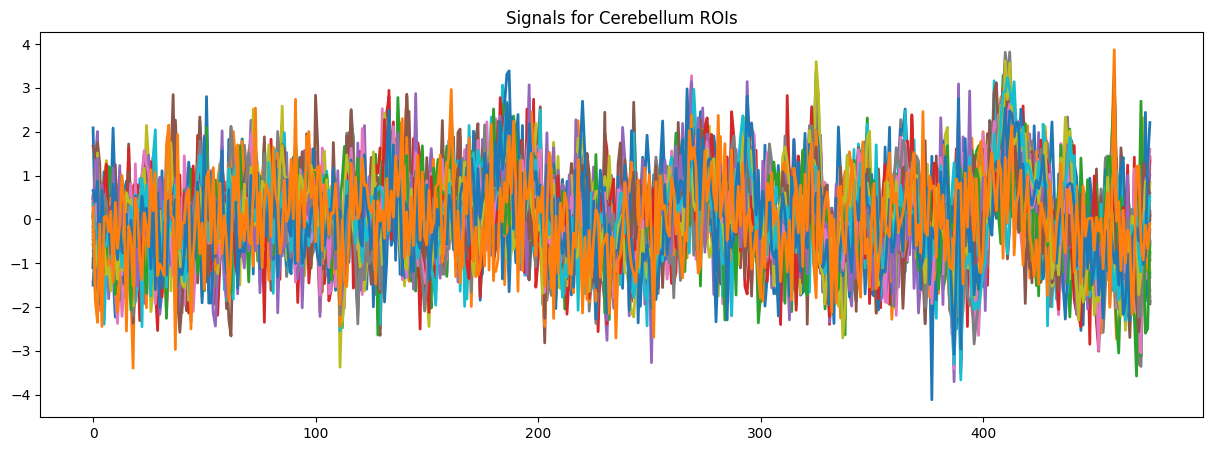

In [11]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
for label_idx in range(len(cb_atlas_labels)-1):
    ax.plot(
        cb_data_ts[:, label_idx], linewidth=2, label=cb_atlas_labels['Label'][label_idx + 1]
    )  # 0 is background
ax.set_title("Signals for Cerebellum ROIs")
plt.show()

## Run for All Subjects

In [86]:
cb_subj_data_ts = dict()

n_tr = cb_data_ts.shape[0]

for temp_label in cb_atlas_labels['Label'][1:]:
    cb_subj_data_ts[temp_label] = pd.DataFrame(columns=list(range(n_tr)),
                                               index=subjs_list)

for subj in subjs_list:
    # Find functional data
    fmri_run_paths = glob.glob(os.path.join(bids_dir, 'derivatives', 'fmriprep',
                                        subj, 'func',
                                        '*space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'))

    # Sort to ensure the run number is correct
    fmri_run_paths.sort()
    
    print('Loading run 1 data for '+subj)
    
    # Import confounds
    confounds_raw_filenames = glob.glob(os.path.join(bids_dir, 'derivatives', 'fmriprep',
                                            subj, 'func',
                                            '*desc-confounds_timeseries.tsv'))
    confounds_raw_filenames.sort()

    confounds_run1 = pd.read_csv(confounds_raw_filenames[0], sep='\t')
    confounds_run1 = confounds_run1[relv_confounds]
    confounds_run1 = confounds_run1.fillna(0)
    
    cb_data_ts = masker.fit_transform(fmri_run_paths[0], confounds_run1)
    
    cb_data_ts_df = pd.DataFrame(cb_data_ts, columns=cb_atlas_labels['Label'][1:])
    cb_data_ts_df.to_csv(outp_dir+'subject_data/'+subj+'_cb_atlas_ts.csv', index=False)
    
        

Loading run 1 data for sub-NET011
Loading run 1 data for sub-NET012
Loading run 1 data for sub-NET016
Loading run 1 data for sub-NET017
Loading run 1 data for sub-NET018
Loading run 1 data for sub-NET019
Loading run 1 data for sub-NET022
Loading run 1 data for sub-NET023
Loading run 1 data for sub-NET025
Loading run 1 data for sub-NET026
Loading run 1 data for sub-NET029
Loading run 1 data for sub-NET030
Loading run 1 data for sub-NET032
Loading run 1 data for sub-NET033
Loading run 1 data for sub-NET034
Loading run 1 data for sub-NET035
Loading run 1 data for sub-NET036
Loading run 1 data for sub-NET037
Loading run 1 data for sub-NET038
Loading run 1 data for sub-NET039
Loading run 1 data for sub-NET041
Loading run 1 data for sub-NET042
Loading run 1 data for sub-NET046
Loading run 1 data for sub-NET047
Loading run 1 data for sub-NET048
Loading run 1 data for sub-NET049
Loading run 1 data for sub-NET050
Loading run 1 data for sub-NET052
Loading run 1 data for sub-NET056
Loading run 1 

In [255]:
subj_ts_files = glob.glob(outp_dir+'subject_data/*_cb_atlas_ts.csv')
len(subj_ts_files)

380

In [256]:
run_trs = {'1':476, '2':480, '3':476, '4':472, '5':268, '6':191, '7':505}


cb_subj_data_ts = dict()

for temp_label in cb_atlas_labels['Label'][1:]:
    cb_subj_data_ts[temp_label] = pd.DataFrame(columns=['Participant_ID','Run', 'n_tr'])

i_row = 0

for subj in subjs_list:
    # Find run numbers for subject
    subj_ts_files = glob.glob(outp_dir+'subject_data/'+subj+'*_cb_atlas_ts.csv')
    subj_ts_files.sort()
    subj_run_nums = [x.split('run-')[-1][0] for x in subj_ts_files]
    
    for run_idx in range(len(subj_run_nums)):
        temp_file_path = subj_ts_files[run_idx]
        cb_data_ts_df = pd.read_csv(temp_file_path)
        n_tr = len(cb_data_ts_df)

        if n_tr != run_trs[subj_run_nums[run_idx]]:
            continue
    
        for temp_label in cb_roi_names:
            cb_subj_data_ts[temp_label].loc[i_row, 'Participant_ID'] = subj
            cb_subj_data_ts[temp_label].loc[i_row, 'Run'] = subj_run_nums[run_idx]
            cb_subj_data_ts[temp_label].loc[i_row, 'n_tr'] = n_tr
            cb_subj_data_ts[temp_label].loc[i_row, range(n_tr)] = cb_data_ts_df[temp_label].to_list()

        i_row += 1

In [257]:
# Conduct one-sample t-tests at each time point for each ROI

# Create dictionary for t and p values
cb_subj_data_ts_t = dict()
#cb_subj_data_ts_p = dict()

for temp_label in cb_roi_names:
    cb_subj_data_ts_t[temp_label] = dict()

    for run_num in cb_subj_data_ts[temp_label]['Run'].unique():
        
        temp_run_data = cb_subj_data_ts[temp_label][cb_subj_data_ts[temp_label]['Run'] == run_num]
        temp_run_data = temp_run_data.dropna(axis=1)

        n_tr = temp_run_data.iloc[0]['n_tr']
        cb_subj_data_ts_t[temp_label][run_num] = pd.DataFrame(columns=list(range(n_tr-1)),
                                               index=['mean', 't', 'p'])
        
        for i_col in temp_run_data.columns[3:]:
            temp_stats = stats.ttest_1samp(temp_run_data.loc[:,i_col].to_list(), 
                                           popmean=0)
            temp_mean = np.mean(temp_run_data.loc[:, i_col])
            
            cb_subj_data_ts_t[temp_label][run_num].loc['mean',i_col] = temp_mean
            cb_subj_data_ts_t[temp_label][run_num].loc['t',i_col] = temp_stats.statistic
            cb_subj_data_ts_t[temp_label][run_num].loc['p',i_col] = temp_stats.pvalue
            
        
        # FDR correction
        temp_p_adj = stats.false_discovery_control(cb_subj_data_ts_t[temp_label][run_num].loc['p'].to_list())
        cb_subj_data_ts_t[temp_label][run_num].loc['p_fdr'] = temp_p_adj
        
        # Export
        cb_subj_data_ts_t[temp_label][run_num].to_csv(outp_dir+'group_results/'+temp_label+'_run-'+run_num+'_ts_stats.csv')


In [258]:
for temp_label in cb_roi_names:
    for run_num in cb_subj_data_ts[temp_label]['Run'].unique():
        cb_subj_data_ts_t[temp_label][run_num].loc['sig_tw'] = 0
        
        for i_col in range(len(cb_subj_data_ts_t[temp_label][run_num].columns)-2):
            count_sig = (cb_subj_data_ts_t[temp_label][run_num].loc['p_fdr',i_col:i_col+2] < .05).sum()
            if count_sig == 3:
                cb_subj_data_ts_t[temp_label][run_num].loc['sig_tw',i_col:i_col+2] = 1
        
        cb_subj_data_ts_t[temp_label][run_num].to_csv(outp_dir+'group_results/'+temp_label+'_run-'+run_num+'_ts_stats.csv', index=False)

cb_subj_data_ts_t[temp_label][run_num].head()

,0,1,2,3,4,5,6,7,8,9,...,495,496,497,498,499,500,501,502,503,504
mean,-0.236846,-0.264922,-0.190986,-0.138926,-0.153266,-0.067556,-0.17904,-0.427539,0.026001,0.029511,...,-0.175784,-0.117106,-0.233005,-0.109205,-0.296688,-0.213653,-0.201316,-0.228022,-0.221612,0.085504
t,-1.280112,-1.516988,-1.061518,-0.772464,-0.966784,-0.422033,-1.084692,-2.440495,0.154096,0.16693,...,-0.915196,-0.563854,-1.266846,-0.531236,-1.902505,-1.20999,-1.037229,-1.31281,-1.037149,0.444991
p,0.208265,0.137546,0.295155,0.444618,0.339765,0.675379,0.284892,0.01944,0.878349,0.868311,...,0.36586,0.576166,0.21292,0.598347,0.064704,0.233756,0.306185,0.197121,0.306221,0.658851
p_fdr,0.361423,0.265888,0.468721,0.598752,0.507637,0.795898,0.45881,0.060228,0.919398,0.917357,...,0.524095,0.734757,0.36573,0.749789,0.151474,0.39613,0.476592,0.343262,0.476592,0.787039
sig_tw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000


In [259]:
cb_roi_list = cb_atlas_labels['Label'][1:].to_list()

In [260]:
# Combine runs to be one time series

cb_group_data_ts = dict()

for temp_label in cb_roi_list:
    cb_group_data_ts[temp_label] = pd.DataFrame()
    
    for run_num in cb_subj_data_ts_t[temp_label].keys():
        run_df = cb_subj_data_ts_t[temp_label][run_num].T
        run_df['Run'] = run_num

        cb_group_data_ts[temp_label] = pd.concat([cb_group_data_ts[temp_label], run_df])
        cb_group_data_ts[temp_label] = cb_group_data_ts[temp_label].reset_index(drop=True)

In [261]:
cb_group_data_ts[temp_label]

,mean,t,p,p_fdr,sig_tw,Run
0,0.189959,0.721226,0.473668,0.640528,0,1
1,-0.34991,-2.089927,0.041019,0.132824,0,1
2,-0.363917,-2.461823,0.016817,0.079258,0,1
3,-0.21026,-1.752121,0.085038,0.226136,0,1
4,-0.203262,-1.301801,0.198131,0.374248,0,1
...,...,...,...,...,...,...
2863,-0.213653,-1.20999,0.233756,0.39613,0,7
2864,-0.201316,-1.037229,0.306185,0.476592,0,7
2865,-0.228022,-1.31281,0.197121,0.343262,0,7
2866,-0.221612,-1.037149,0.306221,0.476592,0,7


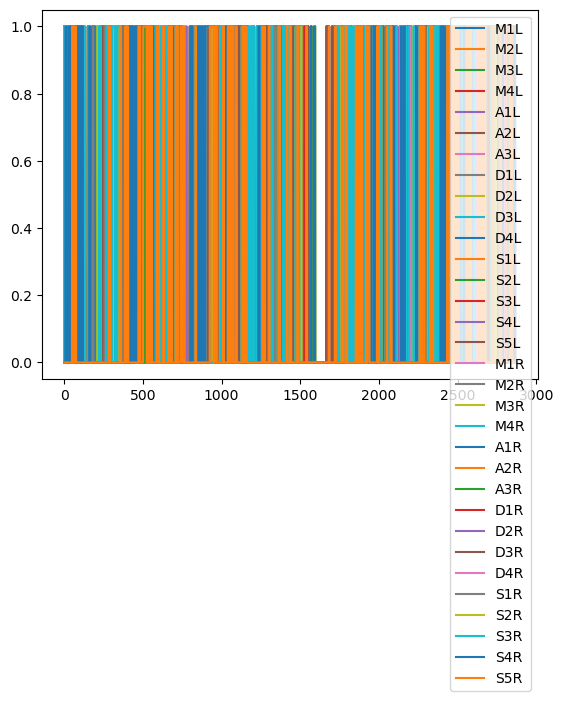

In [262]:
plt.figure()

for temp_label in cb_roi_names:
    cb_group_data_ts[temp_label]['sig_tw'].plot(label=temp_label)
    
plt.legend()

<Axes: xlabel='None', ylabel='mean'>

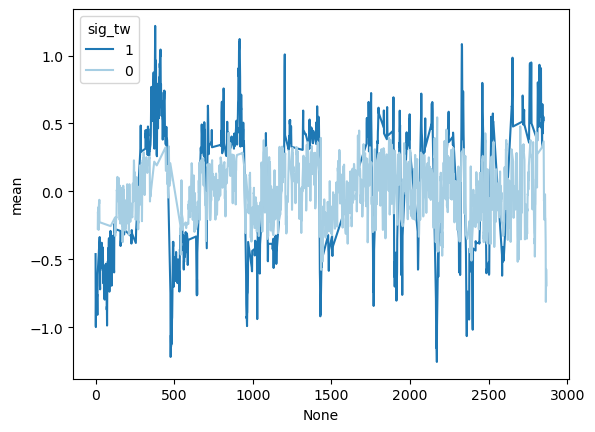

In [265]:
import seaborn as sns
sns.lineplot(data=cb_group_data_ts['S1R'], x=cb_group_data_ts['S1R'].index, y='mean', 
             hue='sig_tw', hue_order=[1,0], palette=(sns.color_palette("Paired")[1],
                                                     sns.color_palette("Paired")[0]))

<Axes: xlabel='None', ylabel='mean'>

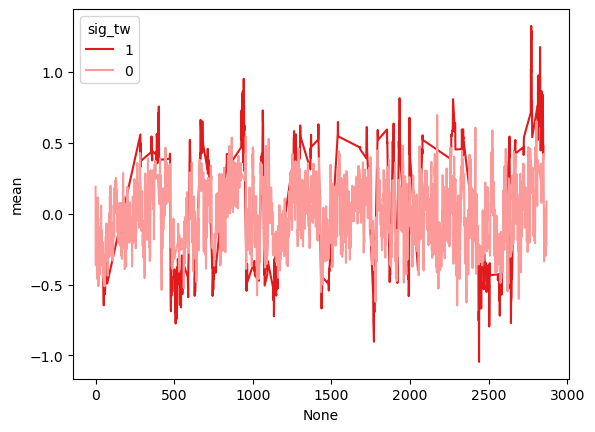

In [266]:
sns.lineplot(data=cb_group_data_ts['S5R'], x=cb_group_data_ts['S1R'].index, y='mean', 
             hue='sig_tw', hue_order=[1,0], palette=(sns.color_palette("Paired")[5],
                                                     sns.color_palette("Paired")[4]))

In [250]:
# Calculate mutual agreement between each cerebellum ROI
from sklearn.metrics import mutual_info_score

# Create empty dataframe to serve as matrix
sig_roi_mtx = pd.DataFrame(columns=cb_roi_list, 
                           index=cb_roi_list)

for temp_roi_a in cb_roi_list:
    temp_data_a = cb_group_data_ts[temp_roi_a]['sig_tw']
    
    for temp_roi_b in cb_roi_list:
        temp_data_b = cb_group_data_ts[temp_roi_b]['sig_tw']
        
        temp_score = sum(temp_data_a == temp_data_b) / len(temp_data_a)
        
        sig_roi_mtx.loc[temp_roi_a, temp_roi_b] =  temp_score


<Axes: >

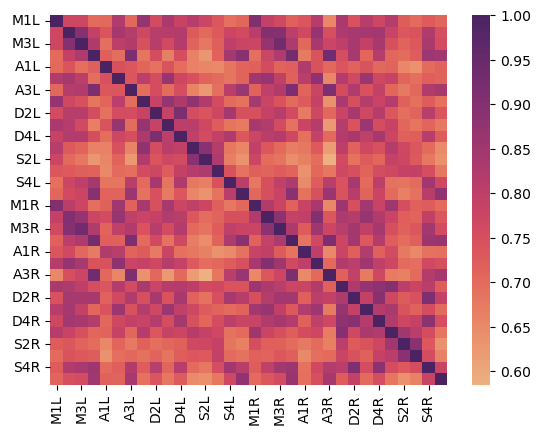

In [254]:
import seaborn as sns

sns.heatmap(sig_roi_mtx.apply(pd.to_numeric), cmap='flare')

# Annotation Analysis